#### Import necessary packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import logging
import time

#### Check mps is avaliable

In [3]:
# Check mps is avaliable
if not torch.backends.mps.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('mps')

print(f"Using device: {device}")

Using device: mps


#### Fix random seed

In [4]:
# Set random seed
seed_np = np.random.seed(2)
seed = torch.manual_seed(2)

#### Hyperparameters

In [5]:
# Hyperparameters
params = {
    "lr": 1e-6,
    "weight_decay": 1e-7,
    "epochs": 2000,
    "batch_size": 64,
    "num_workers": 0,  # have some problems with num_workers > 0
    "eval_rate": 0.2,
}

#### Process data

Slice the global sst data, using $5°S ~ 5°N, 120°W ~ 170°W$

In [6]:

# Load SST data
data_path = './sst.mon.mean.trefadj.anom.1880to2018.nc'
ds = xr.open_dataset(data_path)

# Slice the data (lat 85~95 for 5S~5N degrees, lon 190~240 for 120W~170W degrees)
sst_train = ds['sst'].sel(time=slice('1960-01-01', '2005-12-31')).isel(lat=slice(85, 95), lon=slice(190, 240))
sst_test = ds['sst'].sel(time=slice('2007-01-01', '2017-12-31')).isel(lat=slice(85, 95), lon=slice(190, 240))

# Convert to numpy arrays and reshape for model input
X_train = sst_train.values.reshape(-1, 1, sst_train.shape[1], sst_train.shape[2])
X_test = sst_test.values.reshape(-1, 1, sst_test.shape[1], sst_test.shape[2])

# Normalize the training and testing datasets
mean = X_train.mean()
std = X_train.std()
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

# Load and process label data
label_data_path = './nino34.long.anom.data.txt'
sst_labels = pd.read_csv(label_data_path, delim_whitespace=True, header=None)
sst_labels.columns = ['Year'] + [f'Month_{i}' for i in range(1, 13)]
sst_labels = sst_labels.set_index('Year')

# Extract labels for training and testing
y_train = sst_labels.loc[1960:2005].to_numpy().flatten()
y_test = sst_labels.loc[2007:2017].to_numpy().flatten()

# Define the dataset class for PyTorch
class SSTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Initialize DataLoader objects
X_train, X_eval, y_train, y_eval = train_test_split(X_train_normalized, y_train, test_size=params["eval_rate"], random_state=seed_np)
train_loader = DataLoader(SSTDataset(X_train, y_train), batch_size=params["batch_size"], shuffle=True)
eval_loader = DataLoader(SSTDataset(X_eval, y_eval), batch_size=params["batch_size"], shuffle=False)
test_loader = DataLoader(SSTDataset(X_test_normalized, y_test), batch_size=params["batch_size"], shuffle=False)

# Output shapes for confirmation
print(X_train.shape, y_train.shape)
print(X_eval.shape, y_eval.shape)
print(X_test_normalized.shape, y_test.shape)

(441, 1, 10, 50) (441,)
(111, 1, 10, 50) (111,)
(132, 1, 10, 50) (132,)


#### Define model

In [7]:
# Define the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer to reduce dimensions

        self.num_flat_features = 32 * (10 // 4) * (50 // 4)
        
        self.fc1 = nn.Linear(self.num_flat_features, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, self.num_flat_features)  # Flatten the output of the last convolutional layers
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output a single logit
        return x

#### Configurations

In [8]:
# Initialize model, optimizer, and loss function
model = CNN().to(device)  # mps
optimizer = optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
criterion = nn.MSELoss()

#### Training and Testing

Use `Early Stopping`, base on the evaluation loss. Adjust the limit to perform early stop.

(Here, we use a high limit and high epoches to let the training process overfit.)

In [9]:
# Configure logging
logging.basicConfig(filename='training_v2.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Arrays to keep track of train and test losses
train_losses = np.zeros(params["epochs"])
eval_losses = np.zeros(params["epochs"])

def train_model():
    logging.info(f'Starting training, Epochs: {params["epochs"]}, Batch Size: {params["batch_size"]}, Learning Rate: {params["lr"]}, Weight Decay: {params["weight_decay"]}')
    best_train_loss = float('inf')
    start_time = time.time()

    # Training loop
    for epoch in tqdm(range(params["epochs"]), desc='Training progress'):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Ensure outputs are of correct shape
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Record the training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses[epoch] = avg_train_loss

        # Log the epoch results
        message = f'Epoch {epoch + 1}/{params["epochs"]}: Train Loss: {avg_train_loss:.4f}'
        logging.info(message)
        
        # Evaluate the model
        model.eval()
        running_eval_loss = 0.0
        with torch.no_grad():
            for inputs, labels in eval_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                running_eval_loss += loss.item()
                
        # Record the evaluation loss
        avg_eval_loss = running_eval_loss / len(eval_loader)
        eval_losses[epoch] = avg_eval_loss
                
        # Log the evaluation results
        message = f'Epoch {epoch + 1}/{params["epochs"]}: Eval Loss: {avg_eval_loss:.4f}'
        logging.info(message)
        
        # Save the best model if the evaluation loss decreases
        if avg_eval_loss < best_train_loss:
            best_train_loss = avg_eval_loss
            torch.save(model.state_dict(), 'best_model_v2.pth')
            logging.info('  Eval loss decreased, saving model...')
            
        # Early stopping
        if epoch > 2000 and eval_losses[epoch] > eval_losses[epoch - 100]:
            logging.info('Early stopping')
            print('Early stopping')
            break
              
    # Training complete  
    train_time = time.time() - start_time
    print(f'Training time for {epoch} epochs: {train_time:.2f} seconds')


def test_model(model_path='best_model_v2.pth'):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  # Ensure outputs are of correct shape
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    print(f'Test MSE Loss: {avg_test_loss:.4f}')


train_model()
test_model()

Training progress: 100%|██████████| 2000/2000 [01:16<00:00, 26.03it/s]


Training time for 1999 epochs: 76.86 seconds
Test MSE Loss: 0.0297


#### Visualize training result

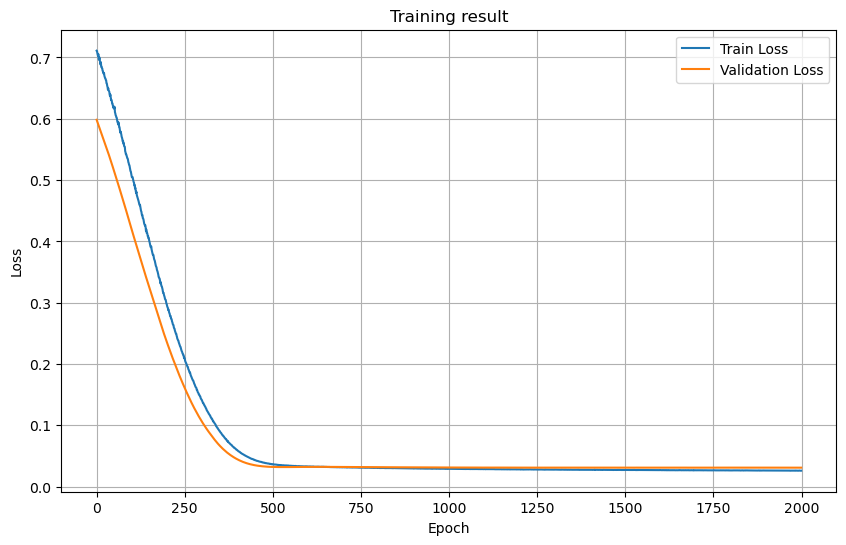

In [10]:
# Plot training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training result")
plt.legend()
plt.savefig('hw9_training_result_v2.png')
plt.grid()
plt.show()

#### Plot predicted Nino34

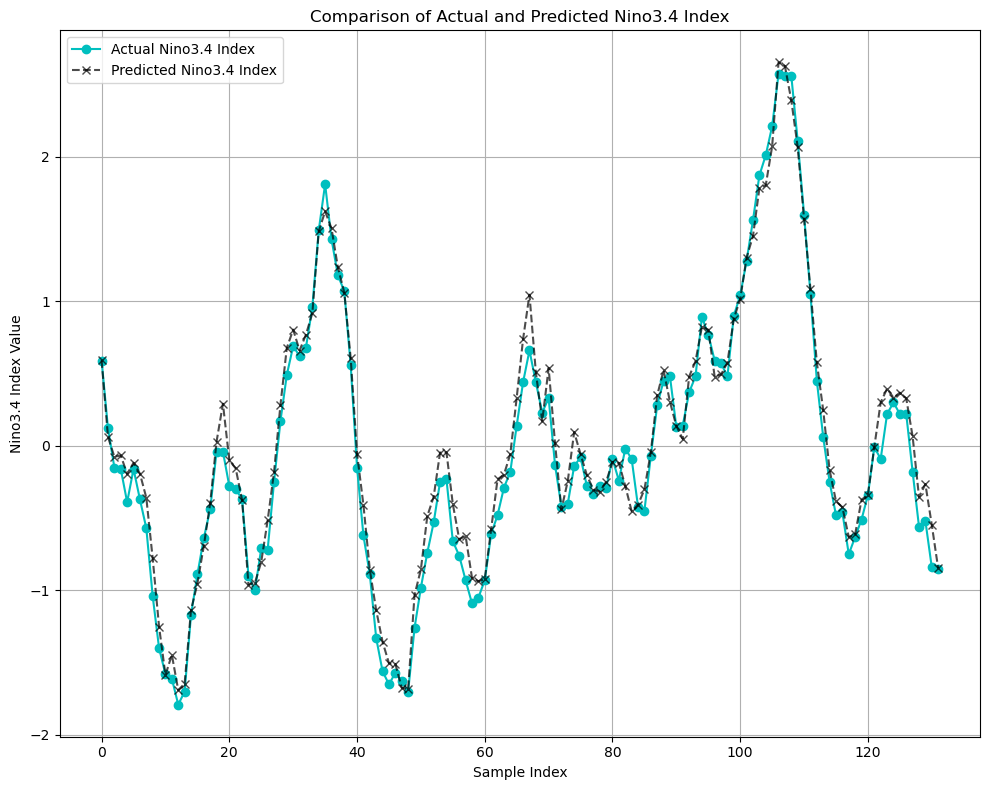

In [11]:
def test_model(model_path='best_model_v2.pth'):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  # Ensure the output is of correct shape
            predictions.extend(outputs.detach().cpu().numpy()) # Move to CPU and convert to NumPy
            actuals.extend(labels.detach().cpu().numpy())

    return predictions, actuals


def plot_results(predictions, actuals):
    plt.figure(figsize=(10, 8))
    plt.plot(actuals, label='Actual Nino3.4 Index', color='c', marker='o')
    plt.plot(predictions, label='Predicted Nino3.4 Index', color='k', linestyle='--', marker='x', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Nino3.4 Index')
    plt.xlabel('Sample Index')
    plt.ylabel('Nino3.4 Index Value')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig('hw9_prediction_v2.png')
    plt.show()


predictions, actuals = test_model('best_model_v2.pth')
plot_results(predictions, actuals)